In [1]:
import torch
from torchvision import models, transforms
import torch.optim as optimizers
from PIL import Image
import numpy
import matplotlib.pyplot as pyplot
from IPython import display
import numpy as np

In [2]:
#VGG-19 besteht aus zwei Teilen: 1. Convolutions+Pooling 2. Classifieres
# .features beschrenkt das Model auf den 1. Teil (also nur die Convolutions)
vgg_model = models.vgg19(weights='DEFAULT').features

#freezing parameters -> nur target soll verändert werden
for parameter in vgg_model.parameters():
    parameter.requires_grad_(False) #only optimize target image, not the other parameters

torch_device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu") #use gpu if possible

vgg_model.to(torch_device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [3]:
def load_image(path_to_image, shape=None):
    loaded_image = Image.open(path_to_image).convert("RGB")

    # Bigger pictures will slow down the training process
    MAXIMUM_SIZE = 500
    if max(loaded_image.size) > MAXIMUM_SIZE:
        size = (MAXIMUM_SIZE, MAXIMUM_SIZE)
    else:
        size = loaded_image.size

    if shape is not None:
        size = shape #.size gibt eh schon ein Tupel zurück

    image_transformations = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.495, 0.455, 0.405),
                             (0.255, 0.220, 0.230))
    ])

    loaded_image = image_transformations(loaded_image)[:3, :, :].unsqueeze(0)

    return loaded_image

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
8
0


In [16]:
original_image = load_image('imgs/women.jpg').to(torch_device) #bilder zum torch.device schicken
style_image = load_image("styleimages/the-girls-of-avignon-Picasso.jpg", shape=original_image.shape[-2:]).to(torch_device) #Style Bild soll genau die gleiche Shape haben, wie das Orginalbild

#visualize the image after tranformation
def display_image(tensor_image):
    image_to_show = tensor_image.to("cpu").clone().detach() #Kopie erzeugen

    image_to_show = image_to_show.numpy().squeeze()  #undo unsqueeze()
    image_to_show = image_to_show.transpose(1, 2, 0)
    image_to_show = image_to_show * numpy.array((0.255, 0.220, 0.230)) + numpy.array((0.495, 0.455, 0.405)) #unnormalize the image
    image_to_show = image_to_show.clip(0, 1) #numpy.clip -> clips the edges

    return image_to_show

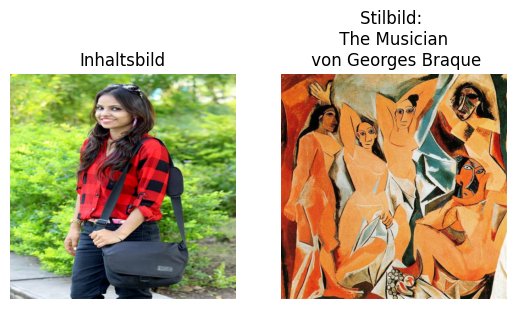

In [17]:
#figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=(30, 20))

axis1 = pyplot.subplot(121)
axis1.set_title("Inhaltsbild")
pyplot.axis('off')
axis1.imshow(display_image(original_image))
axis2 = pyplot.subplot(122)
axis2.set_title("Stilbild: \n The Musician \n von Georges Braque")
axis2.imshow(display_image(style_image))
pyplot.axis('off')
pyplot.savefig("Eingabebilder43.png")
#ensures that we didnt make a mistake by processing the images

In [18]:
#extract the key features of the images
def extract_features(image, model, layers = None):
    if layers is None:
        layers = {
            "0": "conv1_1",
            "5": "conv2_1",
            "10": "conv3_1",
            "19": "conv4_1",
            "25": "conv4_2",
            "28": "conv5_1"
        }

    input1 = image
    features = {}

    for name, layer in model._modules.items():
        input1 = layer(input1)

        if name in layers:
            features[layers[name]] = input1

    return features

In [19]:
original_features = extract_features(original_image, vgg_model, {"25": "conv4_2"})
style_features = extract_features(style_image, vgg_model)

In [20]:
def calculate_gram_matrix(tensor_image):
    batch_size, depth, height, width = tensor_image.size()

    tensor_image = tensor_image.view(depth, -1)

    gram_matrix = torch.mm(tensor_image, tensor_image.t()) #multiply by the transposed image

    return gram_matrix

In [21]:
def compute_total_variation_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())


In [22]:
style_gram_matrices = {layer: calculate_gram_matrix(style_features[layer]) for layer in style_features}#calculate gram_matrix for every layer

altered_image = original_image.clone().requires_grad_(True).to(torch_device)

In [23]:
#optimize model (the heigher the weight, the larger the effect. Higher Weight on early layers mean larger style artifacts
# -> more emphathsis on larger features then smaller ones)
style_weights = {"conv1_1": 1.,
                 "conv2_1": 1.,
                 "conv3_1": 1.,
                 "conv4_1": 1.,
                 "conv5_1": 1.}

optimizer = optimizers.Adam([altered_image]) #can try different ones than Adam

original_image_weight = 1 #is typically recommanded to be 1

style_image_weight = 10000 #high value! but can try different ones

#total_variation_weight = 10

In [24]:
#torch.backends.cudnn.benchmark = True

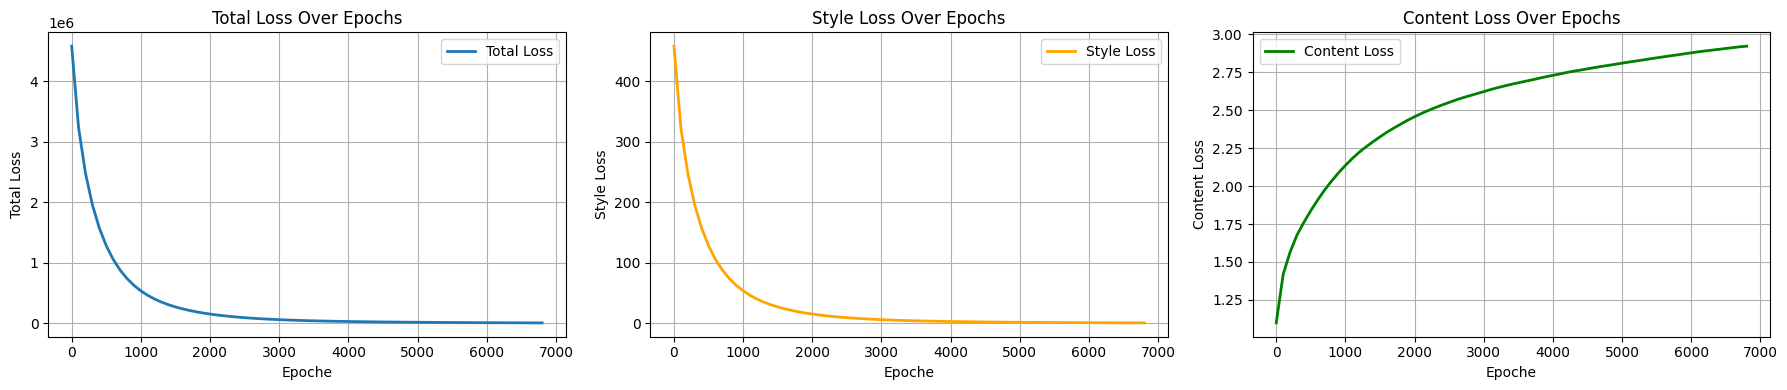

In [ ]:
%%time
NUMBER_OF_EPOCHS = 10000 #can change this

total_loss_for_plt = []  # Initialize an empty list to store total losses
style_loss_for_plt = []  # Initialize an empty list to store style losses
content_loss_for_plt = []  # Initialize an empty list to store content losses

for index in range(1, NUMBER_OF_EPOCHS+1):
    altered_features = extract_features(altered_image, vgg_model) #extract features at every epoch

    style_loss = 0

    original_image_loss = torch.mean((altered_features["conv4_2"] - original_features["conv4_2"]) **2) #mean squared error

    for layer in style_weights:
        altered_feature = altered_features[layer] #get the feature for every single weight

        altered_gram_matrix = calculate_gram_matrix(altered_feature)

        style_matrix = style_gram_matrices[layer]

        layer_style_loss = torch.mean((altered_gram_matrix - style_matrix) ** 2) * style_weights[layer] #mean squared error * layer_weight

        _, depth, height, width = altered_feature.shape

        style_loss += layer_style_loss / (depth * height * width)
        
        #total_variation_loss = compute_total_variation_loss(altered_feature) * total_variation_weight

    total_loss = original_image_loss * original_image_weight + style_loss * style_image_weight

    optimizer.zero_grad()

    total_loss.backward()

    optimizer.step()

    if index % 100 == 0:
        display.clear_output(wait=True)

        total_loss_for_plt.append(total_loss.detach().cpu().item())  # Append the total loss to the list
        style_loss_for_plt.append(style_loss.detach().cpu().item())  # Append the style loss to the list
        content_loss_for_plt.append(original_image_loss.detach().cpu().item())  # Append the content loss to the list

        # Create subplots
        fig, axes = pyplot.subplots(1, 3, figsize=(18, 4))

        # Plot total loss
        axes[0].plot(np.arange(1, index + 1, 100), total_loss_for_plt, label='Total Loss', linewidth=2.0)
        axes[0].set_xlabel("Epoche")
        axes[0].set_ylabel("Total Loss")
        axes[0].set_title("Total Loss Over Epochs")
        axes[0].legend()
        axes[0].grid(True)

        # Plot style loss
        axes[1].plot(np.arange(1, index + 1, 100), style_loss_for_plt, label='Style Loss', linewidth=2.0, color='orange')
        axes[1].set_xlabel("Epoche")
        axes[1].set_ylabel("Style Loss")
        axes[1].set_title("Style Loss Over Epochs")
        axes[1].legend()
        axes[1].grid(True)

        # Plot content loss
        axes[2].plot(np.arange(1, index + 1, 100), content_loss_for_plt, label='Content Loss', linewidth=2.0, color='green')
        axes[2].set_xlabel("Epoche")
        axes[2].set_ylabel("Content Loss")
        axes[2].set_title("Content Loss Over Epochs")
        axes[2].legend()
        axes[2].grid(True)

        pyplot.tight_layout()
        if index == NUMBER_OF_EPOCHS:
            pyplot.savefig("Graphen.png")
        pyplot.show()

        pyplot.imshow(display_image(altered_image))
        pyplot.title("Epoche: " + str(index))
        pyplot.axis('off')
        if index == NUMBER_OF_EPOCHS:
            pyplot.savefig("Ausgabebild18.png")
        pyplot.show()

In [ ]:
print("Minimal- und Maximalwerte der Verlustfunktionen: ")
print(" ")
print("Totaler Verlust:")
print("Minimum: ", "{:.2f}".format(np.min(total_loss_for_plt)), ", Maximum: ", "{:.2f}".format(np.max(total_loss_for_plt)))
print(" ")
print("Stilverlust:")
print("Minimum: ", "{:.2f}".format(min(style_loss_for_plt)),", Maximum: ", "{:.2f}".format(max(style_loss_for_plt)))
print(" ")
print("Inhaltsverlust:")
print("Minimum: ", "{:.2f}".format(min(content_loss_for_plt)),", Maximum: ", "{:.2f}".format(max(content_loss_for_plt)))